In [1]:
%load_ext autoreload
%autoreload 2
%xmode Plain

from precompiled import *

Exception reporting mode: Plain


In [2]:
from data import *

train_dataset, val_dataset, test_dataset

Running tokenizer on train dataset:   0%|          | 0/2204 [00:00<?, ? examples/s]

(Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 1763
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 220
 }),
 Dataset({
     features: ['input_ids', 'attention_mask', 'labels'],
     num_rows: 221
 }))

In [11]:
fine_tuned = BartForConditionalGeneration.from_pretrained(model_name)  # type: BartForConditionalGeneration  # Just for comparsion of performance

In [12]:
# Fine-Tuning

data_collator = DataCollatorForSeq2Seq(tokenizer, model=fine_tuned)

DIR_FINETUNE = create_work_dir("tmp/smz/fine-tuning/")
last_checkpoint = get_last_checkpoint(DIR_FINETUNE)
print(f"last checkpoint: {last_checkpoint}")
training_args = Seq2SeqTrainingArguments(
    output_dir=DIR_FINETUNE,
    overwrite_output_dir=True,
    num_train_epochs=30,  # if more, will overfit.
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    eval_strategy="steps",
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=2,
    logging_dir=DIR_FINETUNE,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,
    log_level="warning",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    warmup_steps=500,
    # prediction_loss_only=True,predict_with_generate
    predict_with_generate=True,

    # max_steps=2,  # TODO
)

trainer = Seq2SeqTrainer(
    model=fine_tuned,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train(resume_from_checkpoint=last_checkpoint)

print_rouge_score(trainer, test_dataset)

# save
fine_tuned.save_pretrained(DIR_FINETUNE)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


last checkpoint: None


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
100,2.967900,0.397921,0.560842,0.445290,0.422189,0.455366
200,0.873400,0.406849,0.660067,0.558261,0.499630,0.539249
300,0.280900,0.536534,0.694941,0.597733,0.521298,0.568439
400,0.096100,0.583816,0.693688,0.592221,0.520139,0.584070


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'test_loss': 0.4620197117328644, 'test_rouge1': 0.7178428456302859, 'test_rouge2': 0.6174638919793287, 'test_rougeL': 0.5417299771160848, 'test_rougeLsum': 0.5994859702177436, 'test_runtime': 59.2504, 'test_samples_per_second': 3.73, 'test_steps_per_second': 0.118}


In [13]:
# Distillation

from distillation import *

DIR_DISTIL = create_work_dir("tmp/smz/distillation/")
last_checkpoint = get_last_checkpoint(DIR_DISTIL)

teacher = BartForConditionalGeneration.from_pretrained(DIR_FINETUNE)  # type: BartForConditionalGeneration
# teacher has no need to update itself
teacher.requires_grad_(False)
teacher.eval()

student = create_student(teacher)
print_size(student)

distiller_model = Distiller(teacher=teacher, student=student)

training_args = TrainingArguments(
    output_dir=DIR_DISTIL,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    warmup_steps=500,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=2,
    learning_rate=5e-5,
    logging_dir=DIR_DISTIL,
    logging_steps=200,
    logging_first_step=True,
    log_level="warning",
    save_safetensors=False,
    fp16=torch.cuda.is_available(),

    # max_steps=2,  # TODO
)

trainer = Trainer(
    model=distiller_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train(resume_from_checkpoint=last_checkpoint)

print_rouge_score_2(student, test_dataset)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Model size: 0.86 GB


Step,Training Loss,Validation Loss
200,75.775200,8.986676
400,40.023000,6.746188
600,32.022000,5.794469
800,28.536100,5.373487
1000,26.767300,5.145839
1200,25.767200,5.021893
1400,25.281800,4.975522


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


{'test_loss': 1.1748368740081787, 'test_model_preparation_time': 0.0024, 'test_rouge1': 0.7165056423822127, 'test_rouge2': 0.617316267408287, 'test_rougeL': 0.5512152425752284, 'test_rougeLsum': 0.6045522744541821, 'test_runtime': 43.4277, 'test_samples_per_second': 5.089, 'test_steps_per_second': 0.161}


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


last checkpoint: None


Output()

Step,Training Loss,Validation Loss
100,1.559300,0.622390
200,1.400200,0.658832
300,1.011200,0.733224
400,0.460400,0.797249


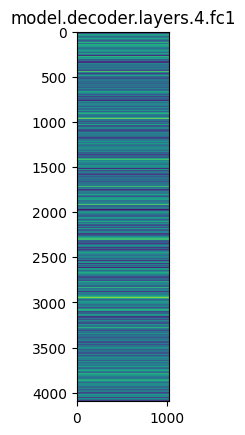

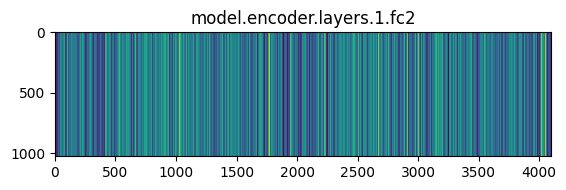

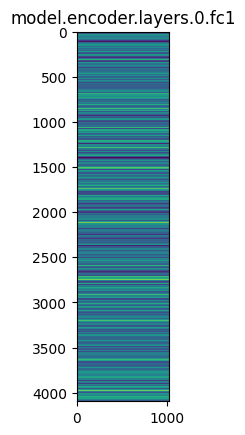

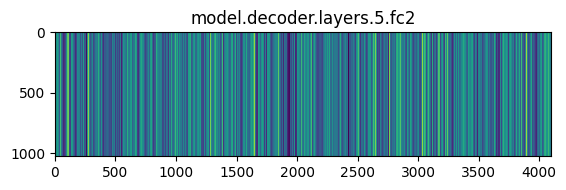

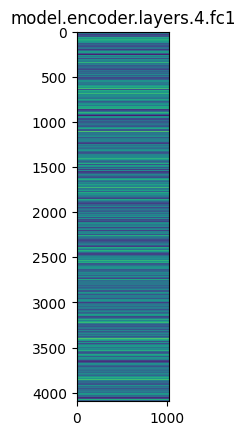

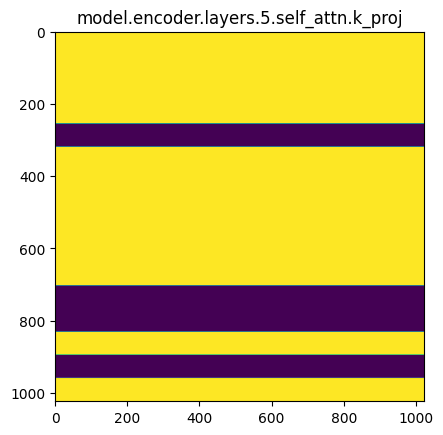

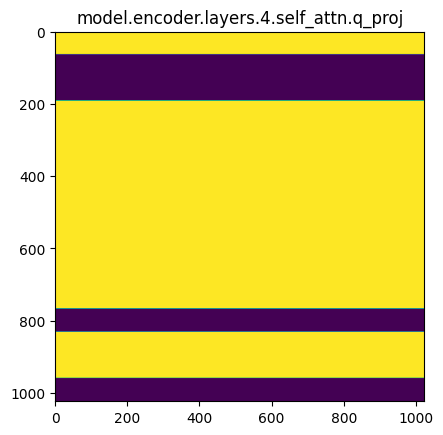

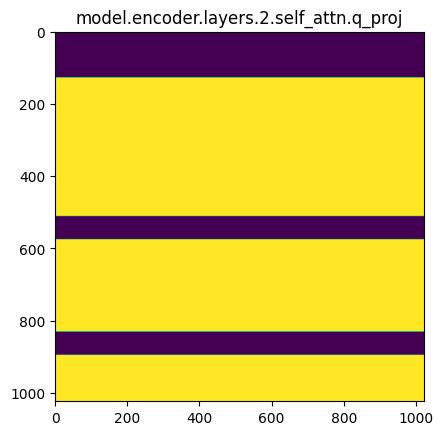

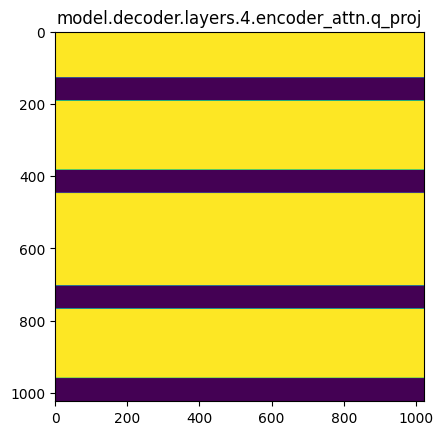

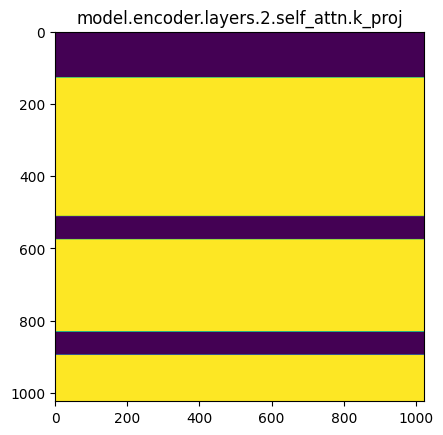

model.encoder.layers.0.self_attn.k_proj: row density: 1.0; col density: 1.0
model.encoder.layers.0.self_attn.v_proj: row density: 1.0; col density: 1.0
model.encoder.layers.0.self_attn.q_proj: row density: 1.0; col density: 1.0
model.encoder.layers.0.self_attn.out_proj: row density: 1.0; col density: 1.0
model.encoder.layers.0.fc1: row density: 0.4; col density: 1.0
model.encoder.layers.0.fc2: row density: 1.0; col density: 0.4
model.encoder.layers.1.self_attn.k_proj: row density: 1.0; col density: 1.0
model.encoder.layers.1.self_attn.v_proj: row density: 1.0; col density: 1.0
model.encoder.layers.1.self_attn.q_proj: row density: 1.0; col density: 1.0
model.encoder.layers.1.self_attn.out_proj: row density: 1.0; col density: 1.0
model.encoder.layers.1.fc1: row density: 0.4; col density: 1.0
model.encoder.layers.1.fc2: row density: 1.0; col density: 0.4
model.encoder.layers.2.self_attn.k_proj: row density: 1.0; col density: 1.0
model.encoder.layers.2.self_attn.v_proj: row density: 1.0; c

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'test_loss': 0.5399028658866882, 'test_rouge1': 0.7124569537631569, 'test_rouge2': 0.6116857332883305, 'test_rougeL': 0.5286218888132945, 'test_rougeLsum': 0.5785588842797578, 'test_runtime': 43.449, 'test_samples_per_second': 5.086, 'test_steps_per_second': 0.644}


In [14]:
# pruning
from pruning import *

model = student
to_prune = convert_model(model)

# scheduler.progress = 1.0
# scheduler.attn_threshold = scheduler.attn_final_threshold
# scheduler.ffn_threshold = scheduler.ffn_final_threshold

data_collator = DataCollatorForSeq2Seq(tokenizer, model=to_prune)

DIR_PRUNE = create_work_dir("tmp/smz/pruning/")
last_checkpoint = get_last_checkpoint(DIR_PRUNE)
print(f"last checkpoint: {last_checkpoint}")
training_args = Seq2SeqTrainingArguments(
    output_dir=DIR_PRUNE,
    overwrite_output_dir=True,
    num_train_epochs=p_train_config.epochs,
    per_device_train_batch_size=p_train_config.batch_size,
    eval_strategy="steps",
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=2,
    logging_dir=DIR_PRUNE,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,   # predict_with_generate=True works only in evaluation phase
    predict_with_generate=True,
    log_level="warning",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=p_train_config.gradient_accumulation_steps,
    weight_decay=0.01,
    warmup_steps=500,
    save_safetensors=False,  # we share masked scores between K,Q,V and between fc1,fc2.
    prediction_loss_only=True,

    # max_steps=2,  # TODO
)

trainer = Seq2SeqTrainer(
    model=to_prune,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[SchedulerUpdateCallback()],
)

trainer.train(resume_from_checkpoint=last_checkpoint)


print_pruning_density(to_prune)
FFN_freeze(to_prune)
print_linear_density_all(to_prune)
FFN_prune_zeros(to_prune)
ATTN_prune_zeros(to_prune)
print_size(to_prune)

print_rouge_score(trainer, test_dataset)

# print(to_prune)

In [15]:
# PTQ, QAT
from quantization import *

model = to_prune
ptq = get_ptq_model(model)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=ptq)

DIR_QUANTIZE = create_work_dir("tmp/smz/quantization/")
last_checkpoint = get_last_checkpoint(DIR_QUANTIZE)
print(f"last checkpoint: {last_checkpoint}")
training_args = Seq2SeqTrainingArguments(
    output_dir=DIR_QUANTIZE,
    overwrite_output_dir=True,
    num_train_epochs=q_train_config.epochs,
    per_device_train_batch_size=q_train_config.batch_size,
    eval_strategy="steps",
    save_strategy='steps',
    save_steps=1000,
    save_total_limit=1,
    logging_dir=DIR_QUANTIZE,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,
    log_level="warning",
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=q_train_config.gradient_accumulation_steps,
    weight_decay=0.01,
    warmup_steps=500,
    prediction_loss_only=True,

    # max_steps=2,  # TODO
)

trainer = Seq2SeqTrainer(
    model=ptq,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train(resume_from_checkpoint=last_checkpoint)

print_rouge_score(trainer, test_dataset)

freeze(ptq)
print_size(ptq)

FINAL_FILE = DIR_QUANTIZE + "final.pth"
torch.save(ptq, FINAL_FILE)  # TODO: save state dict only and save the scale dict in json.

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


last checkpoint: None


Step,Training Loss,Validation Loss
100,0.213300,0.636715
200,0.146500,0.669147


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'test_loss': 0.5591731071472168, 'test_rouge1': 0.7079365533268913, 'test_rouge2': 0.6043373138997292, 'test_rougeL': 0.523560178331491, 'test_rougeLsum': 0.5794820210297275, 'test_runtime': 43.7582, 'test_samples_per_second': 5.05, 'test_steps_per_second': 0.64}
Model size: 0.34 GB


In [16]:
model = torch.load(FINAL_FILE)
thaw(model)

def print_summary(summarizer, text, answer, name: str):
    gen_summary = summarizer(text)[0]["summary_text"]
    score = rouge_score.compute(predictions=[gen_summary], references=[answer])
    scores = {k: round(v, 4) for k, v in score.items()}
    print(f">>> {name}\t: Generated Summary: [{gen_summary}]")
    print(f"{scores}")

fine_tuned.eval()
summarize1 = pipeline(
    'summarization',
    model=fine_tuned,
    tokenizer=tokenizer,
    device=device_summary,
)
model.eval()
summarize2 = pipeline(
    'summarization',
    model=model,
    tokenizer=tokenizer,
    device=device_summary,
)
random_samples = random.sample(range(len(test_dataset)), 5)
for idx in random_samples:
    text = tokenizer.decode(test_dataset[idx]['input_ids'], skip_special_tokens=True)
    answer = tokenizer.decode(test_dataset[idx]['labels'], skip_special_tokens=True)
    print(f"=================== {idx} =====================")
    print_summary(summarize1, text, answer, "origin")
    print("===========================")
    print_summary(summarize2, text, answer, "opt")
    print()


=================== 163 =====================
>>> origin	: Generated Summary: [Pakistanis are now hoping that energy and telecoms, two of the strongest sectors in Pakistan, draw some of the Arab money to the KSE.Pakistani investors are expecting the Kse to repeat, if not improve on, its 2002 performance.In 2002, the K SE index rose 112% and was the world's best performing stock market, with the index rising 112%."Coupled with the 7% GDP growth expected by June this year, I am least surprised at the market's performance," says Mr Lakhani.The Karachi Stock Exchange (KSE) has recorded its largest single day gain, surging 3]
{'rouge1': 0.68, 'rouge2': 0.5354, 'rougeL': 0.28, 'rougeLsum': 0.28}
>>> opt	: Generated Summary: [Market analysts are inclined to agree with Mr Lakhani, arguing that there are a number of major factors behind the KSE's performance.The KSE index closed at 6709.93 - an overall gain of nearly 400 points in the first two trading days of the week.Pakistani investors are e

In [18]:
print_rouge_score_2(fine_tuned, test_dataset)
print_rouge_score_2(model, test_dataset)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


{'test_loss': 0.4620197117328644, 'test_model_preparation_time': 0.0044, 'test_rouge1': 0.7178428456302859, 'test_rouge2': 0.6174638919793287, 'test_rougeL': 0.5417299771160848, 'test_rougeLsum': 0.5994859702177436, 'test_runtime': 59.0581, 'test_samples_per_second': 3.742, 'test_steps_per_second': 0.119}


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

{'test_loss': 0.5567031502723694, 'test_model_preparation_time': 0.0024, 'test_rouge1': 0.699763117846487, 'test_rouge2': 0.5926591506171733, 'test_rougeL': 0.5141747872052533, 'test_rougeLsum': 0.5685196222494486, 'test_runtime': 37.5316, 'test_samples_per_second': 5.888, 'test_steps_per_second': 0.187}
